## importing dependencies 



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

### importing the training data of GOOG historical prices

In [2]:
data = pd.read_csv('trainData.csv') 


In [3]:
data.head(10)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
5,1/10/2012,313.70,315.72,307.30,621.43,"8,824,000"
6,1/11/2012,310.59,313.52,309.40,624.25,"4,817,800"
7,1/12/2012,314.43,315.26,312.08,627.92,"3,764,400"
8,1/13/2012,311.96,312.30,309.37,623.28,"4,631,800"
9,1/17/2012,314.81,314.81,311.67,626.86,"3,832,800"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


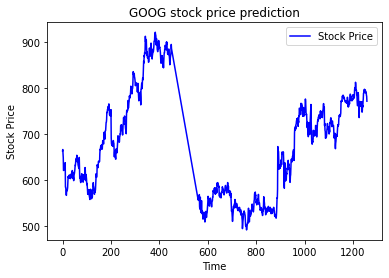

In [18]:
plt.plot(data['Close'], color = 'blue', label = 'Stock Price')
plt.title('GOOG stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## choosing the close column 


In [6]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce') #turning the Close column to numeric
data = data.dropna() #romeving the NA values
trainData = data.iloc[:,4:5].values #selecting only the closing prices for training


## scaling the values in the range of 0-1 for best preformances 

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1149, 1)

## preparing the data for LSTM
 since its a time series problem we took 60 as timestep for our learning : given *60 closing values* as an input data the *61st value* is our output

In [8]:
X_train = []
y_train = []

for i in range (60,1149): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

ps : LSTM take a 3D tensor (seq_len,timestep,batch_size)

In [9]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(1089, 60, 1)

## building the model 

In [10]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [11]:
hist = model.fit(X_train, y_train, epochs = 5, batch_size = 32, verbose=2)

Epoch 1/5
35/35 - 11s - loss: 0.0376 - 11s/epoch - 303ms/step
Epoch 2/5
35/35 - 5s - loss: 0.0138 - 5s/epoch - 136ms/step
Epoch 3/5
35/35 - 5s - loss: 0.0105 - 5s/epoch - 131ms/step
Epoch 4/5
35/35 - 5s - loss: 0.0089 - 5s/epoch - 153ms/step
Epoch 5/5
35/35 - 5s - loss: 0.0109 - 5s/epoch - 130ms/step


### ploting the training loss


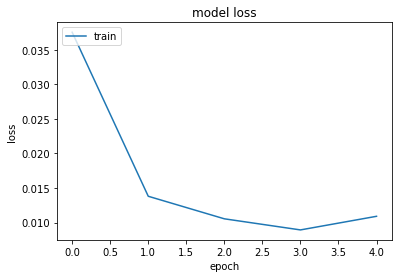

In [12]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### testing the model on new data


In [13]:
testData = pd.read_csv('GOOG.csv') #importing the test data
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce') #turning the close column to numerical type
testData = testData.dropna() #droping the NA values
testData = testData.iloc[:,4:5] #selecting the closing prices for testing
y_test = testData.iloc[60:,0:].values #selecting the labels 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length): #doing the same preivous preprocessing 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(192, 60, 1)

In [14]:
y_pred = model.predict(X_test) #predicting the new values


In [22]:
y_pred_1_b = sc.inverse_transform(y_pred) #inversing the scaling transformation for ploting 
print(y_pred_1_b)

[[1054.1558 ]
 [1051.4607 ]
 [1049.3967 ]
 [1048.1329 ]
 [1047.5905 ]
 [1047.4031 ]
 [1047.2144 ]
 [1046.8326 ]
 [1046.3387 ]
 [1045.8351 ]
 [1045.0996 ]
 [1043.9958 ]
 [1042.5645 ]
 [1040.8046 ]
 [1038.9489 ]
 [1037.1921 ]
 [1035.9978 ]
 [1035.7103 ]
 [1036.5266 ]
 [1038.537  ]
 [1041.23   ]
 [1044.1979 ]
 [1046.861  ]
 [1048.8236 ]
 [1049.9778 ]
 [1050.4573 ]
 [1050.4467 ]
 [1049.9813 ]
 [1048.9094 ]
 [1047.2394 ]
 [1045.0186 ]
 [1042.2546 ]
 [1038.7909 ]
 [1034.552  ]
 [1030.0798 ]
 [1025.9607 ]
 [1022.5914 ]
 [1020.1729 ]
 [1018.823  ]
 [1018.29456]
 [1018.70325]
 [1020.08453]
 [1022.4275 ]
 [1025.5989 ]
 [1029.3483 ]
 [1033.2924 ]
 [1036.9913 ]
 [1040.3628 ]
 [1043.4359 ]
 [1046.3267 ]
 [1049.1827 ]
 [1051.8744 ]
 [1054.2891 ]
 [1056.3275 ]
 [1058.0629 ]
 [1059.4237 ]
 [1060.2899 ]
 [1060.8132 ]
 [1061.3687 ]
 [1062.2053 ]
 [1063.6108 ]
 [1065.8119 ]
 [1068.6244 ]
 [1071.6445 ]
 [1074.4701 ]
 [1076.8094 ]
 [1078.7004 ]
 [1080.2383 ]
 [1081.5353 ]
 [1082.6205 ]
 [1083.5417 ]
 [1084

### ploting the results

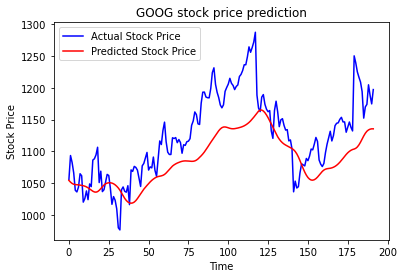

In [23]:
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred_1_b, color = 'red', label = 'Predicted Stock Price')
plt.title('GOOG stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()